In [ ]:
import pandas as pd
import numpy as np
import time
import datetime


import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score as cvs
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка данных
data_build = pd.read_excel(r'/content/drive/My Drive/building_data.xlsx')
corona = pd.read_excel(r'/content/drive/My Drive/corona.xlsx')
weather = pd.read_excel(r'/content/drive/My Drive/weather.xls')

In [ ]:
# Обработка датасета с ковидом
for i in range(corona.shape[0]):
  corona['Дата'][i] = corona['Дата'][i][3:5] +  corona['Дата'][i][2] + corona['Дата'][i][0:2] + corona['Дата'][i][5:]
  corona['Дата'][i] = pd.Timestamp(corona['Дата'][i])
corona = corona[corona['Регион'] == 'Москва'][['Дата', 'Заражений за день']]
corona['day'] = pd.to_datetime(corona['Дата']).dt.dayofyear

In [ ]:
# Обработка датасета с погодой
weather = weather.drop(index = range(0, 6), columns = ['Unnamed: ' + str(x) for x in range(2, 13)]).iloc[::-1]
weather.columns = ['time', 'T']
weather.index = range(weather.shape[0])
for i in range(weather.shape[0]):
  weather.time[i] = pd.Timestamp(weather.time[i])

In [ ]:
# Данные о приросте зараженных в Москве
corona.head()

,Дата,Заражений за день,day
40,2020-03-12 00:00:00,21,72
122,2020-03-13 00:00:00,5,73
204,2020-03-14 00:00:00,9,74
286,2020-03-15 00:00:00,0,75
368,2020-03-16 00:00:00,18,76


In [ ]:
# Данные о погоде в Москве
weather.head()

,time,T
0,2018-03-16 00:00:00,-7
1,2018-03-16 00:30:00,-7
2,2018-03-16 01:00:00,-8
3,2018-03-16 01:30:00,-8
4,2018-03-16 02:00:00,-9


In [ ]:
data_build.head(2)

,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_2_e_TM1H_mv_val,_Accumulator_Bus_2_e_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseB_p_TM1H_mv_val,_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseC_p_TM1H_mv_val,_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_3_e_TM1H_mv_val,_Accumulator_Bus_3_e_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseB_p_TM1H_mv_val,_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseC_p_TM1H_mv_val,_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_4_e_TM1H_mv_val,_Accumulator_Bus_4_e_TM1H_mv_qual,_Accumulator_Bus_4_p_TM1H_mv_val,_Accumulator_Bus_4_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseA_p_TM1H_mv_val,_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseB_p_TM1H_mv_val,_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseC_p_TM1H_mv_val,...,_roof_Bus_1_p_TM1H_mv_val,_roof_Bus_1_p_TM1H_mv_qual,_roof_Bus_1_phaseA_p_TM1H_mv_val,_roof_Bus_1_phaseA_p_TM1H_mv_qual,_roof_Bus_1_phaseB_p_TM1H_mv_val,_roof_Bus_1_phaseB_p_TM1H_mv_qual,_roof_Bus_1_phaseC_p_TM1H_mv_val,_roof_Bus_1_phaseC_p_TM1H_mv_qual,_unctrl_load_Bus_1_p_TM1H_mv_val,_unctrl_load_Bus_1_p_TM1H_mv_qual,_unctrl_load_Bus_1_phaseA_p_TM1H_mv_val,_unctrl_load_Bus_1_phaseA_p_TM1H_mv_qual,_unctrl_load_Bus_1_phaseB_p_TM1H_mv_val,_unctrl_load_Bus_1_phaseB_p_TM1H_mv_qual,_unctrl_load_Bus_1_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_1_phaseC_p_TM1H_mv_qual,_unctrl_load_Bus_2_p_TM1H_mv_val,_unctrl_load_Bus_2_p_TM1H_mv_qual,_unctrl_load_Bus_2_phaseA_p_TM1H_mv_val,_unctrl_load_Bus_2_phaseA_p_TM1H_mv_qual,_unctrl_load_Bus_2_phaseB_p_TM1H_mv_val,_unctrl_load_Bus_2_phaseB_p_TM1H_mv_qual,_unctrl_load_Bus_2_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_2_phaseC_p_TM1H_mv_qual,_unctrl_load_Bus_3_p_TM1H_mv_val,_unctrl_load_Bus_3_p_TM1H_mv_qual,_unctrl_load_Bus_3_phaseA_p_TM1H_mv_val,_unctrl_load_Bus_3_phaseA_p_TM1H_mv_qual,_unctrl_load_Bus_3_phaseB_p_TM1H_mv_val,_unctrl_load_Bus_3_phaseB_p_TM1H_mv_qual,_unctrl_load_Bus_3_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_3_phaseC_p_TM1H_mv_qual,_unctrl_load_Bus_4_p_TM1H_mv_val,_unctrl_load_Bus_4_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseA_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseA_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseB_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseB_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseC_p_TM1H_mv_qual
0,2018-03-16 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOD MEAN,-0.002582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.217995,GOOD MEAN,2.275578,GOOD MEAN,2.328169,GOOD MEAN,1.614416,GOOD MEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-16 14:00:00,NaN,NaN,GOOD MEAN,-0.004168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOD MEAN,-0.004389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOD MEAN,-0.005729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.014747,GOOD MEAN,2.224703,GOOD MEAN,2.166507,GOOD MEAN,1.623537,GOOD MEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Неуправляемая нагрузка
data_build['sum'] = data_build['_Bus_1_p_TM1H_mv_val'] + data_build['_Bus_2_p_TM1H_mv_val'] + data_build['_Bus_3_p_TM1H_mv_val'] + data_build['_Bus_4_p_TM1H_mv_val']

In [ ]:
print('NaN значений:', data_build['sum'].isna().sum(), '\n', 'Доля от всех значений:', data_build['sum'].isna().sum()/data_build['sum'].shape[0]*100, '%')

NaN значений: 299 
 Доля от всех значений: 1.4115758663015767 %


In [ ]:
# Массив из потребления,часа, дня недели, месяца и года
to_predict = data_build[['time', 'sum']]
to_predict['hour'] = to_predict['time'].dt.hour
to_predict['weekday'] = to_predict['time'].dt.weekday
to_predict['month'] = to_predict['time'].dt.month
to_predict['year'] = to_predict['time'].dt.year
to_predict['day'] = to_predict['time'].dt.dayofyear

# Заполнение NaN величин ближайшими
to_predict['sum'] = to_predict['sum'].interpolate(method = 'nearest')
to_predict['sum'][0] = to_predict['sum'][1]

In [ ]:
# Функция для задания лагов в 7 дней, в тренировочную выборку берется потребление в тот же час за каждый из 7 предыдущих дней, среднее за неделю и предыдущий час.
def lagging(input, lag_days):
  output = input[24*lag_days:]
  output.index = range(0, output.shape[0])

  for i in range(lag_days):
    output['lag_'+str(i+1)+'_days'] = output['sum']
    for j in range(len(output)):
      output['lag_'+str(i+1)+'_days'][j] = input['sum'][j - (i+1)*24 + lag_days*24]
  output['week_average'] = output.iloc[:, -lag_days:].mean(axis = 1)

  prev_1_hour = input['sum'][24*lag_days -1: -1]
  prev_1_hour.index = range(0, output.shape[0])
  output['prev_1_hour'] = prev_1_hour

  prev_2_hour = input['sum'][24*lag_days -2: -2]
  prev_2_hour.index = range(0, output.shape[0])
  output['prev_2_hour'] = prev_2_hour

  prev_3_hour = input['sum'][24*lag_days -3: -3]
  prev_3_hour.index = range(0, output.shape[0])
  output['prev_3_hour'] = prev_3_hour

  output.index = range(0, output.shape[0])
  output
  return output

In [ ]:
to_predict_lagged = lagging(to_predict, 7)

In [ ]:
# Фильтрация данных от аномалий и выходных дней (отсекаем дни по минимальному и максимальному потреблению)
filtered = pd.DataFrame(columns = to_predict_lagged.columns)
for i in to_predict_lagged['year'].unique():
  for j in to_predict_lagged[to_predict_lagged['year'] == i]['day'].unique():
    day = to_predict_lagged[(to_predict_lagged['year'] == i) & (to_predict_lagged['day'] == j)]
    if day['sum'].max() > 60 and day['sum'].min() > 35:
      filtered = filtered.append(day)

In [ ]:
# Добавление температуры
filtered.index = filtered.time
weather.index = weather.time
filtered['temp'] = weather['T']
filtered.index = range(filtered.shape[0])

filtered['temp'] = filtered.temp.astype(float)

In [ ]:
# Добавление прироста больных ковидом
intersect = pd.Series(list(set(filtered[filtered['year'] == 2020].day.unique()).intersection(set(corona['day'].unique()))))
filtered['infected'] = 0
for i in intersect: 
  filtered['infected'][(filtered['day'] == i) & (filtered['year'] == 2020)] = corona[corona['day'] == i]['Заражений за день'][corona[corona['day'] == i].index[0]]

In [ ]:
filtered

,time,sum,hour,weekday,month,year,day,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,lag_7_days,week_average,prev_1_hour,prev_2_hour,prev_3_hour,infected
0,2018-03-23 13:00:00,126.318770,13,4,3,2018,82,126.846060,125.434964,120.205493,119.648809,44.421022,43.290093,113.578040,99.060640,132.011247,137.964270,146.778251,0
1,2018-03-23 14:00:00,122.800647,14,4,3,2018,82,125.018348,124.649382,121.290103,121.181668,44.101883,43.019381,113.578040,98.976972,126.318770,132.011247,137.964270,0
2,2018-03-23 15:00:00,99.817032,15,4,3,2018,82,110.671709,112.061150,111.913405,110.150256,42.961941,43.784231,113.578040,92.160104,122.800647,126.318770,132.011247,0
3,2018-03-23 16:00:00,79.763998,16,4,3,2018,82,87.752229,89.360713,91.770248,86.406201,45.355458,45.399997,68.391032,73.490840,99.817032,122.800647,126.318770,0
4,2018-03-23 17:00:00,68.781349,17,4,3,2018,82,76.920309,78.230756,78.866346,75.627530,43.917616,44.495351,63.314478,65.910341,79.763998,99.817032,122.800647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21009,2020-10-22 08:00:00,140.921294,8,3,10,2020,296,135.828272,132.026921,140.130295,53.080120,53.067195,127.239623,121.435825,108.972607,134.435036,134.904913,113.806301,4413
21010,2020-10-22 09:00:00,134.155082,9,3,10,2020,296,134.812648,131.804641,144.405416,53.094003,54.032736,122.001280,121.757817,108.844077,140.921294,134.435036,134.904913,4413
21011,2020-10-22 10:00:00,136.018950,10,3,10,2020,296,138.599030,128.196448,140.417924,52.618734,53.085676,125.325649,118.006706,108.035738,134.155082,140.921294,134.435036,4413
21012,2020-10-22 11:00:00,132.726926,11,3,10,2020,296,134.549665,136.348114,138.443793,53.321875,52.947789,124.724858,122.635485,108.995940,136.018950,134.155082,140.921294,4413


In [ ]:
filtered.drop(['time'], axis = 1).astype(float).corr()

,sum,hour,weekday,month,year,day,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,lag_7_days,week_average,prev_1_hour,prev_2_hour,prev_3_hour,temp,infected
sum,1.000000,-0.187232,-0.090795,0.055276,-0.155843,0.054717,0.687318,0.458959,0.429359,0.407656,0.392169,0.519068,0.613143,0.733783,0.949753,0.836898,0.682568,0.066486,-0.168226
hour,-0.187232,1.000000,-0.003406,-0.005748,-0.004943,-0.005842,-0.118562,-0.085554,-0.098416,-0.090057,-0.087652,-0.083363,-0.074210,-0.132932,-0.045115,0.095408,0.233144,0.135963,-0.005986
weekday,-0.090795,-0.003406,1.000000,-0.016508,-0.053417,-0.013276,0.264515,0.451339,0.208053,-0.071192,-0.289400,-0.218059,-0.046017,0.062750,-0.088438,-0.086088,-0.083572,0.053547,-0.027285
month,0.055276,-0.005748,-0.016508,1.000000,-0.312960,0.995460,0.057316,0.058697,0.054323,0.060926,0.080958,0.102300,0.112271,0.110116,0.055072,0.054843,0.054549,0.025230,-0.011441
year,-0.155843,-0.004943,-0.053417,-0.312960,1.000000,-0.311109,-0.143448,-0.136142,-0.135844,-0.138027,-0.148944,-0.149417,-0.133539,-0.205329,-0.155996,-0.156180,-0.156309,-0.009813,0.492760
day,0.054717,-0.005842,-0.013276,0.995460,-0.311109,1.000000,0.061315,0.061520,0.054025,0.059939,0.079114,0.100193,0.112954,0.110615,0.054614,0.054492,0.054303,0.027152,-0.012969
lag_1_days,0.687318,-0.118562,0.264515,0.057316,-0.143448,0.061315,1.000000,0.695814,0.294426,0.245941,0.239048,0.333275,0.503949,0.694785,0.670991,0.604927,0.503458,0.087204,-0.140447
lag_2_days,0.458959,-0.085554,0.451339,0.058697,-0.136142,0.061520,0.695814,1.000000,0.535837,0.101269,0.073349,0.229387,0.359731,0.625832,0.449550,0.403448,0.331550,0.099530,-0.120797
lag_3_days,0.429359,-0.098416,0.208053,0.054323,-0.135844,0.054025,0.294426,0.535837,1.000000,0.528796,0.117033,0.246256,0.367135,0.641121,0.413984,0.365252,0.292996,0.091259,-0.123359
lag_4_days,0.407656,-0.090057,-0.071192,0.060926,-0.138027,0.059939,0.245941,0.101269,0.528796,1.000000,0.562554,0.305398,0.393892,0.650160,0.395622,0.351502,0.285226,0.065783,-0.117100


Text(0, 0.5, 'Потребление')

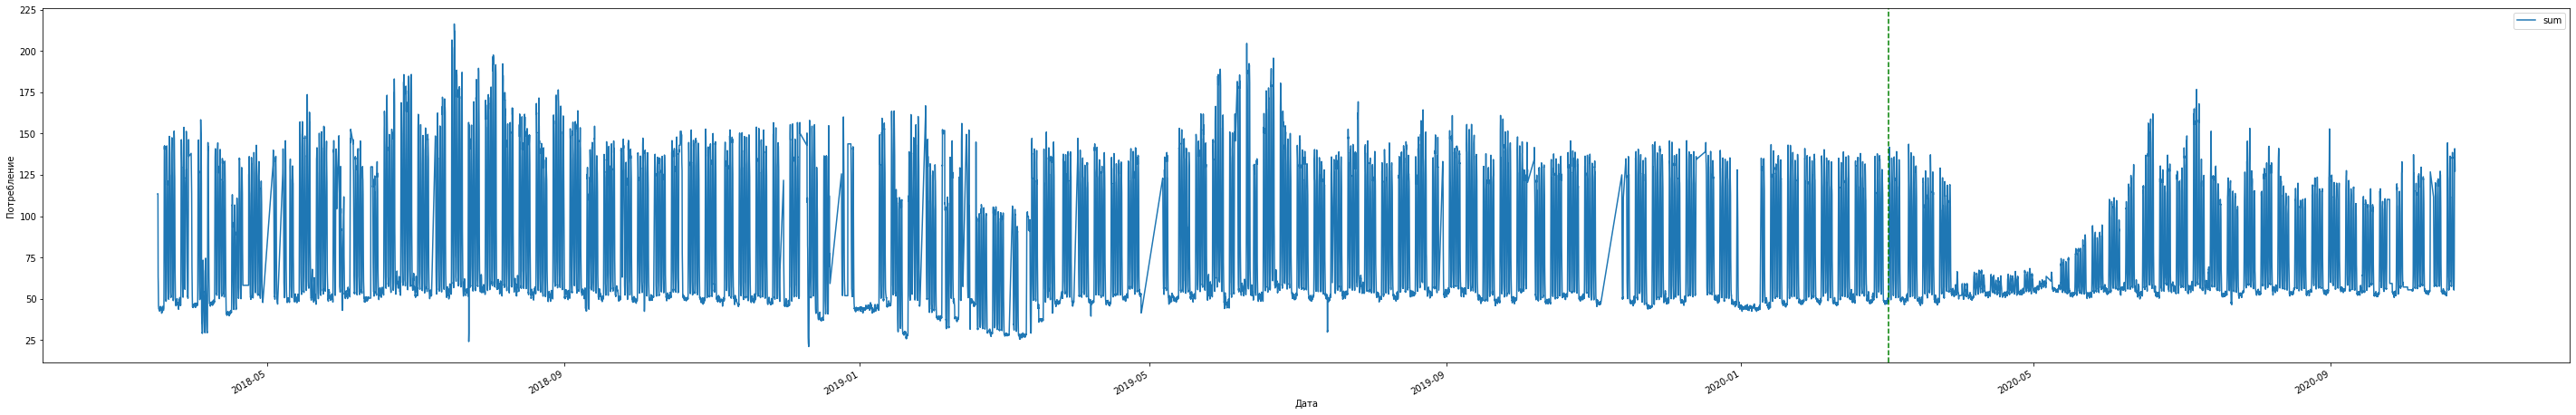

In [ ]:
# График потребления оригинальный
fig, ax = plt.subplots(figsize=(50,8))
to_predict.plot(x='time',y='sum',ax=ax )
# 3 марта 2020 (локдаун в Москве)
qarantine_begin = pd.Timestamp('2020-03-02 00:00:00')
plt.axvline(qarantine_begin, ls = '--', c = 'green')
plt.xlabel('Дата')
plt.ylabel('Потребление')

Text(0, 0.5, 'Потребление')

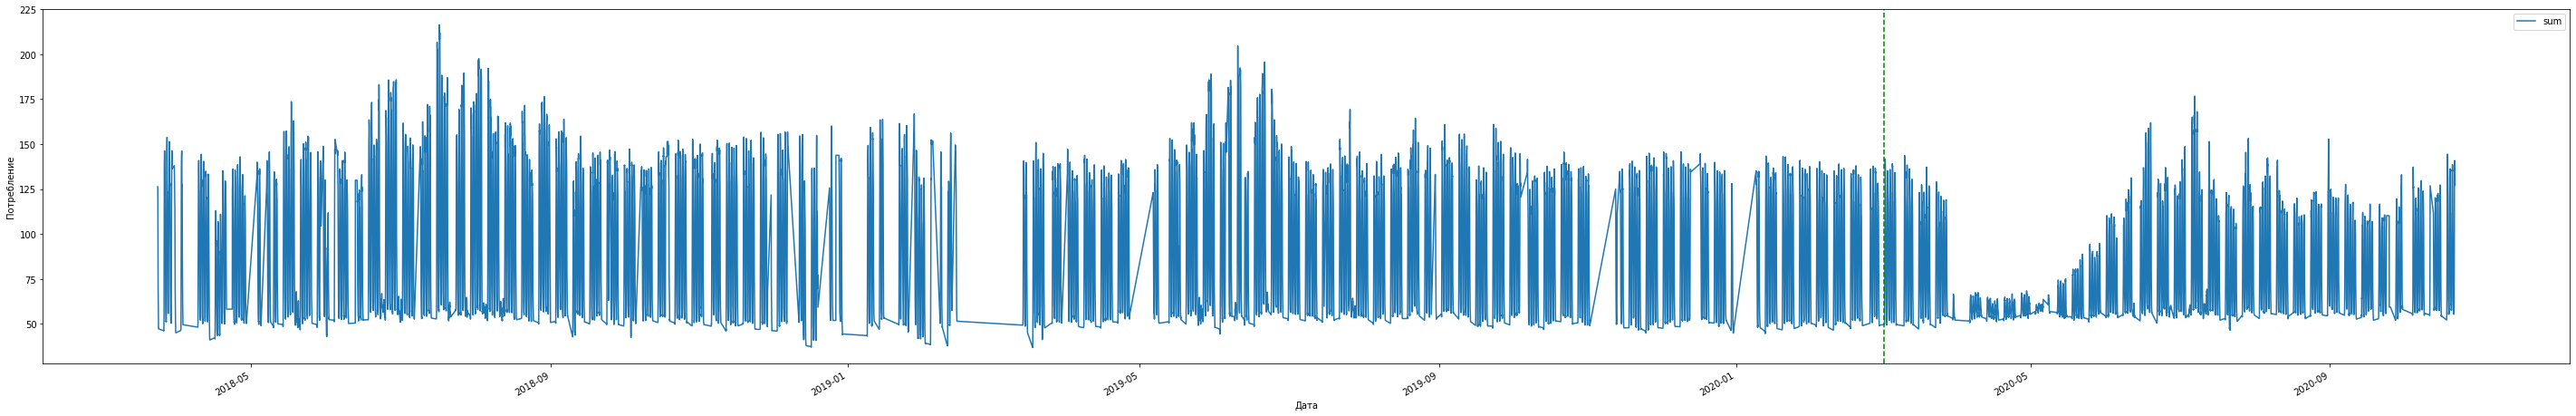

In [ ]:
# График потребления отфильтрованный
fig, ax = plt.subplots(figsize=(50,8))
filtered.plot(x='time',y='sum',ax=ax )
# 3 марта 2020 (локдаун в Москве)
qarantine_begin = pd.Timestamp('2020-03-02 00:00:00')
plt.axvline(qarantine_begin, ls = '--', c = 'green')
plt.xlabel('Дата')
plt.ylabel('Потребление')

In [ ]:
def x_y_split(input):
  '''
  Разделение датасета на признаки и предсказываемую величину
  '''

  X = input.drop(['sum', 'time'], axis = 1)
  y = input[['sum']]

  return X, y

In [ ]:
X, y =  x_y_split(filtered)

In [ ]:
X.head()

,hour,weekday,month,year,day,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,lag_7_days,week_average,prev_1_hour,prev_2_hour,prev_3_hour,infected
0,13,4,3,2018,82,126.846060,125.434964,120.205493,119.648809,44.421022,43.290093,113.578040,99.060640,132.011247,137.964270,146.778251,0
1,14,4,3,2018,82,125.018348,124.649382,121.290103,121.181668,44.101883,43.019381,113.578040,98.976972,126.318770,132.011247,137.964270,0
2,15,4,3,2018,82,110.671709,112.061150,111.913405,110.150256,42.961941,43.784231,113.578040,92.160104,122.800647,126.318770,132.011247,0
3,16,4,3,2018,82,87.752229,89.360713,91.770248,86.406201,45.355458,45.399997,68.391032,73.490840,99.817032,122.800647,126.318770,0
4,17,4,3,2018,82,76.920309,78.230756,78.866346,75.627530,43.917616,44.495351,63.314478,65.910341,79.763998,99.817032,122.800647,0


In [ ]:
y.head()

,sum
0,126.318770
1,122.800647
2,99.817032
3,79.763998
4,68.781349


In [ ]:
splits = 6
tss = TimeSeriesSplit(n_splits= splits)
count = 0
for train_index, test_index in tss.split(X):
  count += 1
  print("TRAIN:", len(train_index), "TEST:", len(test_index))
  if count == 5:
    break

TRAIN: 2042 TEST: 2039
TRAIN: 4081 TEST: 2039
TRAIN: 6120 TEST: 2039
TRAIN: 8159 TEST: 2039
TRAIN: 10198 TEST: 2039


In [ ]:
to_predict_lagged

,time,sum,hour,weekday,month,year,day,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,lag_7_days,week_average,prev_1_hour,prev_2_hour,prev_3_hour
0,2018-03-23 13:00:00,126.318770,13,4,3,2018,82,126.846060,125.434964,120.205493,119.648809,44.421022,43.290093,113.578040,99.060640,132.011247,137.964270,146.778251
1,2018-03-23 14:00:00,122.800647,14,4,3,2018,82,125.018348,124.649382,121.290103,121.181668,44.101883,43.019381,113.578040,98.976972,126.318770,132.011247,137.964270
2,2018-03-23 15:00:00,99.817032,15,4,3,2018,82,110.671709,112.061150,111.913405,110.150256,42.961941,43.784231,113.578040,92.160104,122.800647,126.318770,132.011247
3,2018-03-23 16:00:00,79.763998,16,4,3,2018,82,87.752229,89.360713,91.770248,86.406201,45.355458,45.399997,68.391032,73.490840,99.817032,122.800647,126.318770
4,2018-03-23 17:00:00,68.781349,17,4,3,2018,82,76.920309,78.230756,78.866346,75.627530,43.917616,44.495351,63.314478,65.910341,79.763998,99.817032,122.800647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21009,2020-10-22 08:00:00,140.921294,8,3,10,2020,296,135.828272,132.026921,140.130295,53.080120,53.067195,127.239623,121.435825,108.972607,134.435036,134.904913,113.806301
21010,2020-10-22 09:00:00,134.155082,9,3,10,2020,296,134.812648,131.804641,144.405416,53.094003,54.032736,122.001280,121.757817,108.844077,140.921294,134.435036,134.904913
21011,2020-10-22 10:00:00,136.018950,10,3,10,2020,296,138.599030,128.196448,140.417924,52.618734,53.085676,125.325649,118.006706,108.035738,134.155082,140.921294,134.435036
21012,2020-10-22 11:00:00,132.726926,11,3,10,2020,296,134.549665,136.348114,138.443793,53.321875,52.947789,124.724858,122.635485,108.995940,136.018950,134.155082,140.921294


In [ ]:
# Предсказательная модель
my_lgb = lgb.LGBMRegressor(objective = "poisson",
        metric ="rmse",
        force_row_wise = True,
        sub_row = 0.75,
        bagging_freq = 1,
        lambda_l2 = 0.1,
        verbosity= 1,
        num_iterations = 2000,
        num_leaves= 128,
        min_data_in_leaf = 50 )

In [ ]:
cv_scores = cvs(my_lgb, X.astype(float), y, cv = tss, n_jobs = -1, scoring= 'neg_mean_squared_error')
print(cv_scores.mean())

-59.27267811767064


In [ ]:
# RMSE
print(np.sqrt(cv_scores.mean()*(-1)))

7.6988751202802765


In [ ]:
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X.astype(float), y)
# report selected features
print('Selected Features:')
names = X.columns.values
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])

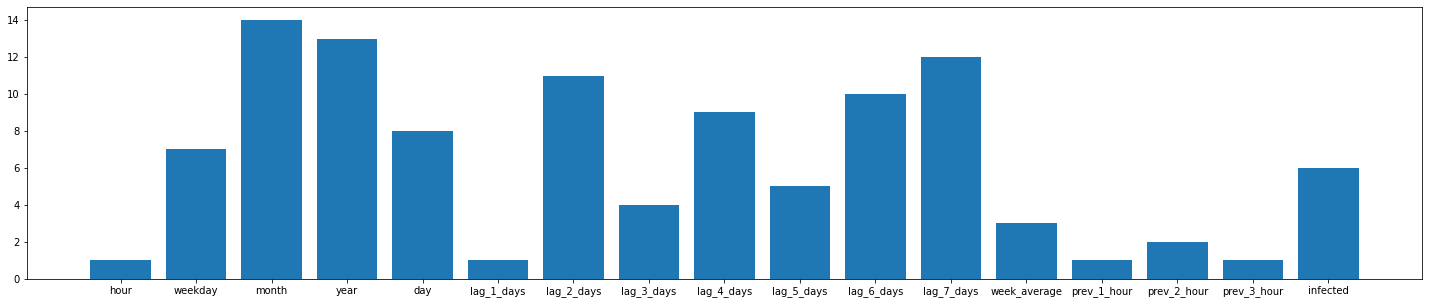

In [ ]:
# plot feature rank
names = X.columns.values
ticks = [i for i in range(len(names))]
plt.figure(figsize = (25, 5))
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.show()

In [ ]:
params = {'num_leaves= 128': [120, 130, 140], 'lambda_l2': [0.05, 0.1, 0.2]}
model = RandomizedSearchCV(my_lgb, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = tss)
model.fit(X.astype(float), y, )
print(model.best_params_)

{'num_leaves= 128': 120, 'lambda_l2': 0.1}


In [ ]:
def preprocess(fname, hourly=True):
    df = pd.read_excel(fname).set_index('time')
    if hourly and len(df) > 0:
        df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='H'))
    return df

def lagging(input, lag_days):
  output = input[24*lag_days:]
  output.index = range(0, output.shape[0])

  for i in range(lag_days):
    output['lag_'+str(i+1)+'_days'] = output['sum']
    for j in range(len(output)):
      output['lag_'+str(i+1)+'_days'][j] = input['sum'][j - (i+1)*24 + lag_days*24]
  output['week_average'] = output.iloc[:, -lag_days:].mean(axis = 1)

  prev_1_hour = input['sum'][24*lag_days -1: -1]
  prev_1_hour.index = range(0, output.shape[0])
  output['prev_1_hour'] = prev_1_hour

  prev_2_hour = input['sum'][24*lag_days -2: -2]
  prev_2_hour.index = range(0, output.shape[0])
  output['prev_2_hour'] = prev_2_hour

  prev_3_hour = input['sum'][24*lag_days -3: -3]
  prev_3_hour.index = range(0, output.shape[0])
  output['prev_3_hour'] = prev_3_hour

  output.index = range(0, output.shape[0])
  return output

def preparation(input):
  temp = input.copy()
  temp['sum'] = temp['_Bus_1_p_TM1H_mv_val'] + temp['_Bus_2_p_TM1H_mv_val'] + temp['_Bus_3_p_TM1H_mv_val'] + temp['_Bus_4_p_TM1H_mv_val']

  # Массив из потребления,часа, дня недели, месяца и года
  to_predict = temp[['time', 'sum']]
  to_predict['hour'] = to_predict['time'].dt.hour
  to_predict['weekday'] = to_predict['time'].dt.weekday
  to_predict['month'] = to_predict['time'].dt.month
  to_predict['year'] = to_predict['time'].dt.year
  to_predict['day'] = to_predict['time'].dt.dayofyear

  # Заполнение NaN величин ближайшими
  to_predict['sum'] = to_predict['sum'].interpolate(method = 'nearest')
  to_predict['sum'][0] = to_predict['sum'][1]

  output = to_predict
  return output

def filtering(input):
  output = pd.DataFrame(columns = input.columns)
  for i in input['year'].unique():
    for j in input[input['year'] == i]['day'].unique():
      day = input[(input['year'] == i) & (input['day'] == j)]
      if day['sum'].max() > 60 and day['sum'].min() > 35:
        output = output.append(day)
  return output

def generate_X_for_next_hour(input):
  time_new = input.iloc[-1]['time'] + datetime.timedelta(hours=1)
  output = pd.DataFrame([time_new])
  output.columns = ['time']
  output['hour'] = output['time'].dt.hour
  output['weekday'] = output['time'].dt.weekday
  output['month'] = output['time'].dt.month
  output['year'] = output['time'].dt.year
  output['day'] = output['time'].dt.dayofyear
  output = input.append(output)
  output.index = range(output.shape[0])
  return output



In [ ]:
def fit(fname):
    global my_lgb, df
    df = preprocess(fname)
    df['time'] = df.index
    df.index = range(df.shape[0])
    to_predict = preparation(df)

    to_predict_lagged = lagging(to_predict, 7)

    filtered = filtering(to_predict_lagged)

    X = filtered.drop(['sum', 'time', 'month', 'year', 'lag_2_days', 'lag_4_days', 'lag_6_days', 'lag_7_days'], axis = 1)
    y = filtered[['sum']]

    my_lgb = lgb.LGBMRegressor(objective = "poisson",
        metric ="rmse",
        force_row_wise = True,
        sub_row = 0.75,
        bagging_freq = 1,
        lambda_l2 = 0.1,
        verbosity= 1,
        num_iterations = 2000,
        num_leaves= 120,
        min_data_in_leaf = 50 )
    
    my_lgb.fit(X.astype(float), y)
    

def predict(dt, extra_data='upd.xlsx'):
    global my_lgb, df
    
    df_upd = preprocess(extra_data)
    df_upd['time'] = df_upd.index
    
    df_new = df.append(df_upd)
    df_new.index = range(df_new.shape[0])
    



    to_predict = preparation(df_new)
    to_predict = to_predict[-14*24:]

    predictions = []
    for i in range(24):

      to_predict = generate_X_for_next_hour(to_predict)

      

      to_predict_lagged = lagging(to_predict, 7)

      X = to_predict_lagged.drop(['sum', 'time', 'month', 'year', 'lag_2_days', 'lag_4_days', 'lag_6_days', 'lag_7_days'], axis = 1).iloc[[-1]]

      y = my_lgb.predict(X)[0]
      to_predict['sum'].iloc[-1] = y
    if df_upd.shape[0] != 0:
      result = to_predict[['time', 'sum']].iloc[-24:-df_upd.shape[0]]
    else:
      result = to_predict[['time', 'sum']].iloc[-24:]
    result.index = result['time']






    
    return result['sum']

In [ ]:
fit('example_data.xlsx')

In [ ]:
initial_date = pd.to_datetime('2020-10-22 10:00:00')
for delta in range(4):
    upd = f'example_{delta}.xlsx'
    result = predict(initial_date + datetime.timedelta(hours=delta), upd)
    print(result)

time
2020-10-22 10:00:00    134.157481
2020-10-22 11:00:00    132.522725
2020-10-22 12:00:00    128.386499
2020-10-22 13:00:00    122.542945
2020-10-22 14:00:00    116.105569
2020-10-22 15:00:00     96.603257
2020-10-22 16:00:00     79.904593
2020-10-22 17:00:00     70.836624
2020-10-22 18:00:00     63.490097
2020-10-22 19:00:00     58.994102
2020-10-22 20:00:00     56.451923
2020-10-22 21:00:00     55.401698
2020-10-22 22:00:00     55.047407
2020-10-22 23:00:00     54.192787
2020-10-23 00:00:00     54.469474
2020-10-23 01:00:00     53.277252
2020-10-23 02:00:00     54.810121
2020-10-23 03:00:00     63.577080
2020-10-23 04:00:00     74.168561
2020-10-23 05:00:00    103.927851
2020-10-23 06:00:00    134.259695
2020-10-23 07:00:00    140.863644
2020-10-23 08:00:00    134.510305
2020-10-23 09:00:00    135.437599
Name: sum, dtype: float64
time
2020-10-22 11:00:00    132.374086
2020-10-22 12:00:00    129.426875
2020-10-22 13:00:00    121.948298
2020-10-22 14:00:00    114.963588
2020-10-22 1

# Проверка модуля

In [ ]:
from mainforecast import fit, predict
# Необходимо иметь предустановленными библиотеки из начала ноутбука (lightgbm, sklearn и т.д.)

In [ ]:
fit('example_data.xlsx')

In [ ]:
initial_date = pd.to_datetime('2020-10-22 10:00:00')
for delta in range(4):
    upd = f'example_{delta}.xlsx'
    result = predict(initial_date + datetime.timedelta(hours=delta), upd)
    print(result)

time
2020-10-22 10:00:00    134.157481
2020-10-22 11:00:00    132.522725
2020-10-22 12:00:00    128.386499
2020-10-22 13:00:00    122.542945
2020-10-22 14:00:00    116.105569
2020-10-22 15:00:00     96.603257
2020-10-22 16:00:00     79.904593
2020-10-22 17:00:00     70.836624
2020-10-22 18:00:00     63.490097
2020-10-22 19:00:00     58.994102
2020-10-22 20:00:00     56.451923
2020-10-22 21:00:00     55.401698
2020-10-22 22:00:00     55.047407
2020-10-22 23:00:00     54.192787
2020-10-23 00:00:00     54.469474
2020-10-23 01:00:00     53.277252
2020-10-23 02:00:00     54.810121
2020-10-23 03:00:00     63.577080
2020-10-23 04:00:00     74.168561
2020-10-23 05:00:00    103.927851
2020-10-23 06:00:00    134.259695
2020-10-23 07:00:00    140.863644
2020-10-23 08:00:00    134.510305
2020-10-23 09:00:00    135.437599
Name: sum, dtype: float64
time
2020-10-22 11:00:00    132.374086
2020-10-22 12:00:00    129.426875
2020-10-22 13:00:00    121.948298
2020-10-22 14:00:00    114.963588
2020-10-22 1